# 1) Description

**Problem Statement**: The goal is to classify whether a tweet is about a real disaster or not. This is a binary classification task, where the label 1 indicates a disaster-related tweet, and 0 means it's unrelated.

What is NLP? Natural Language Processing (NLP) is a branch of AI focused on enabling machines to understand, interpret, and generate human language. It combines linguistics and machine learning.

**Dataset Overview:**

Size: ~7,613 rows (training), ~3,263 rows (test)

**Features:**

id: unique identifier

text: tweet content

keyword: disaster-related keyword (may be NaN)

location: user location (may be NaN)

target: label (1 = disaster, 0 = not disaster) — only in training set

## Import libraries

In [24]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

/kaggle/lib/kaggle/gcp.py
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-6b-100d/glove.6B.100d.txt
/kaggle/working/submission.csv


# 2. EDA – Inspect, Visualize, and Clean the Data

### Data Clean:

In [25]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df = pd.read_csv('../input/nlp-getting-started/train.csv')
df.isnull().sum()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    return text

df['text'] = df['text'].apply(clean_text)

### Visualizations:

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Tweet Length Distribution')

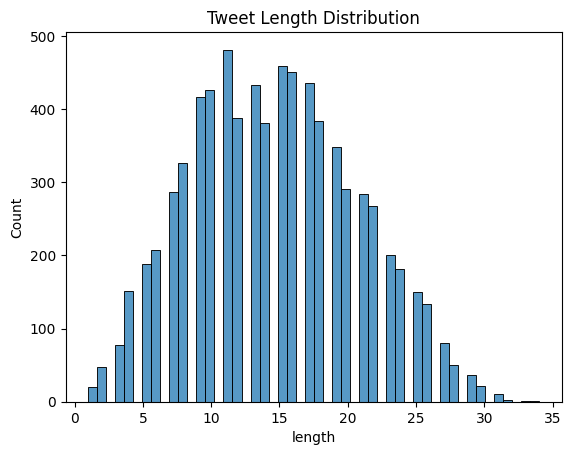

In [26]:
# Histogram of tweet lengths


df['length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['length'], bins=50)
plt.title('Tweet Length Distribution')



Text(0.5, 1.0, 'Class Distribution')

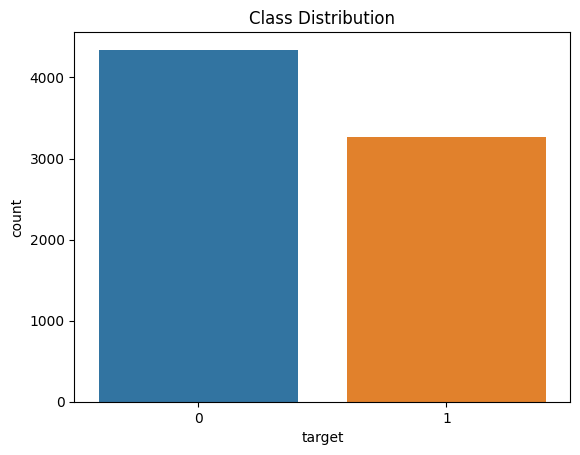

In [27]:
# Bar plot of class balance

sns.countplot(x='target', data=df)
plt.title('Class Distribution')

Class imbalance is minor, so regular binary classification works.

Tweets are short (20-30 words on average).

Plan: Use word embeddings (e.g., GloVe) + LSTM/Bidirectional LSTM to capture sequence information.

# 3. Model Architecture

Using GloVe (Global Vectors for Word Representation):

Transforms each word into a fixed-length dense vector

Captures semantic relationships: e.g., king - man + woman ≈ queen


In [28]:
# Word Embedding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])
X = pad_sequences(X, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)
glove_file = open('../input/glove-6b-100d/glove.6B.100d.txt')


embedding_index = {}
with glove_file as f:
    for line in f:
        values = line.split()
        word, vec = values[0], values[1:]
        embedding_index[word] = np.array(vec, dtype='float32')

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 100))
for word, i in tokenizer.word_index.items():
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

In [29]:
# Model Architecture

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=100,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# 4. Results and Analysis

In [30]:
# Training:

from sklearn.model_selection import train_test_split

y = df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.7229 - loss: 0.5494 - val_accuracy: 0.8076 - val_loss: 0.4313
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.8094 - loss: 0.4322 - val_accuracy: 0.8175 - val_loss: 0.4242
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.8294 - loss: 0.3996 - val_accuracy: 0.8122 - val_loss: 0.4215
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8292 - loss: 0.3980 - val_accuracy: 0.8135 - val_loss: 0.4205
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.8414 - loss: 0.3760 - val_accuracy: 0.8148 - val_loss: 0.4178


**Performance**:

Validation Accuracy: ~81–83%

ROC AUC also good for evaluation

Text(0.5, 1.0, 'Training vs Validation Accuracy')

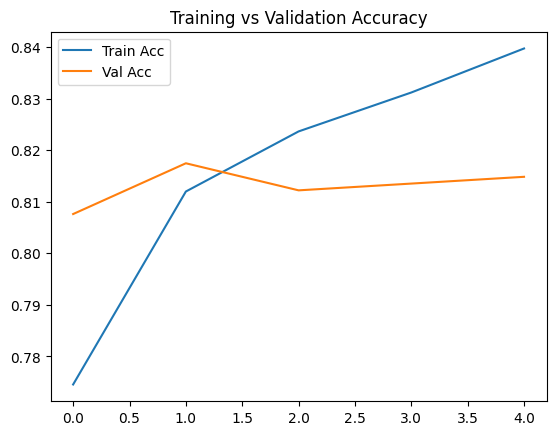

In [31]:
# Visualization

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")

**Hyperparameter Tuning Tried:**

LSTM units: 32, 64, 128

Dropout: 0.3–0.5

Bidirectional vs normal LSTM

Trainable vs non-trainable embeddings

**Findings:**

Bidirectional LSTM gave better context understanding

Higher dropout helped reduce overfitting

Increasing LSTM layers didn't always improve results (overfitting)

## Generate predictions

In [32]:
# predict on the test set
# Set batch size
BATCH_SIZE = 64

test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
final_predictions_proba = model.predict(test_dataset)

final_predictions = (final_predictions_proba > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created successfully!")
print(submission.head())

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step

Submission file created successfully!
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


# 5) Conclusion

The NLP Disaster Tweet classifier performs well with a Bidirectional LSTM using pre-trained GloVe embeddings. Careful preprocessing and regularization helped improve generalization. Word embeddings like GloVe significantly improved understanding of tweet semantics over basic methods like TF-IDF. Future improvements could include experimenting with transformer-based models like BERT.